<a href="https://colab.research.google.com/gist/RJVogel/2e22197c08e1821717f4d6ea186293c6/homework_interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Interpolation problem**

Assuming we have a vector field *v* on a 2D grid with coordinates *x* and *y*. At a specific point (*x0*, *y0*), we need to obtain the value *v0(x0, y0)*. The data is organized with index *i* in *x*-direction and index *j* in *y*-direction. The data structure is shown in the figure below.

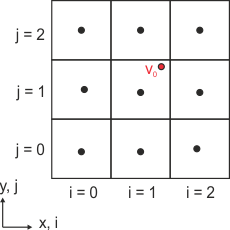

An interpolation problem is set up in the following code examples.

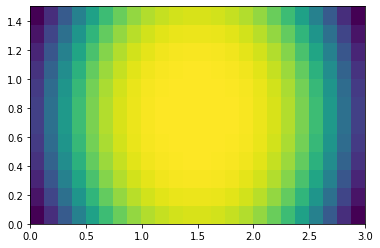

In [1]:
# Import libraries
import numpy as np
from scipy import signal
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate example grid, which ranges from 0 to 6 m for x and 0 to 3 m for
# y. The coordinates x and y are the centroids of the grid tiles, as
# depicted in the figure above.
x_len = 3
y_len = 1.5
x_tile_bnds = np.linspace(0, x_len, int(x_len*8+1))
y_tile_bnds = np.linspace(0, y_len, int(y_len*8+1))
x = 0.5*(x_tile_bnds[1:] + x_tile_bnds[:-1])
y = 0.5*(y_tile_bnds[1:] + y_tile_bnds[:-1])

# Create grid matrices
X,Y = np.meshgrid(x,y)
# Generate example data, which is the distance from the origin at (0, 0)
v = np.cos((X-x_len/2)**2+(Y-y_len/2)**2)

# Show example data (uncomment below to see printed values)
# print('v:\n',np.array_str(v, precision=2, suppress_small=True))

# Plot example data
plt.pcolor(x_tile_bnds, y_tile_bnds, v)

In [2]:
# We need the value at two different positions (x1, y1) and (x2, y2):
x1, y1 = 2.5, 1
x2, y2 = 3, 1.5

# We know the exact solutions v1 and v2 (see how we calculated v above):
v1 = np.cos((x1-x_len/2)**2+(y1-y_len/2)**2)
v2 = np.cos((x2-x_len/2)**2+(y2-y_len/2)**2)

# Print exact solutions:
print('The exact value v1(x1,y1) is: ', v1)
print('The exact value v2(x2,y2) is: ', v2)

The exact value v1(x1,y1) is:  0.4866896677019633
The exact value v2(x2,y2) is:  -0.9463359733389455


A simple code to obtain the interpolated values v1 and v2 with the nearest neighbor method is given in the example below.

In [3]:
# Calculate the euclidean distances between the coordinates and all grid points
eucl_dist_1 = ((X - x1)**2 + (Y - y1)**2)**0.5
eucl_dist_2 = ((X - x2)**2 + (Y - y2)**2)**0.5

# Find the index of the values nearest to the search positions
index1 = np.where(eucl_dist_1 == np.min(eucl_dist_1))
index2 = np.where(eucl_dist_2 == np.min(eucl_dist_2))

# Obtain the values at the search positions by using the previously
# calculated index values. If multiple indices were found, for example on the
# borders of two tiles or even on the corner of four tiles, the mean value of
# all these values is calculated
vi1 = np.mean(v[index1])
vi2 = np.mean(v[index2])

# Print the interpolated results
print('The interpolated value for v1(x1,y1) is: ', vi1)
print('The interpolated value for v2(x2,y2) is: ', vi2)

The interpolated value for v1(x1,y1) is:  0.47587367564592753
The interpolated value for v2(x2,y2) is:  -0.8239043424882614


These values calculated with the nearest neighbor method are close but not accurate. In the following, please try another interpolation method that delivers better results. You can use built-in functions or write your own code. You may reuse any code from the above examples. A good method needs little code and works fast. Please document your code.

Hint: The second point (x2, y2) is actually outside of the vector space spanned by the grid centroids (x, y). For this reason, extrapolation is needed, which may not be provided by a built-in interpolation function.

## Prepare train data and test data

In [63]:
# Please add your code here:
from sklearn.model_selection import train_test_split

# get train data
train_data = np.array(list(zip(X.flatten(),Y.flatten())))
train_obs = v.flatten()

# enlarge the grid area
# generate test data
x_len_test = 3.5
y_len_test = 2
x_tile_test = np.linspace(0, x_len_test, int(x_len_test*10))
y_tile_test = np.linspace(0, y_len_test, int(y_len_test*10))

# Create grid matrices
X_test,Y_test = np.meshgrid(x_tile_test,y_tile_test)
# Generate values at test points
v_test = np.cos((X_test-x_len_test/2)**2+(Y_test-y_len_test/2)**2)

test_data = np.array(list(zip(X_test.flatten(),Y_test.flatten())))
test_obs = v_test.flatten()

## Searching for optimal kriging parameters with cross validation
reference: https://github.com/GeoStat-Framework/PyKrige/blob/develop/examples/08_krige_cv.py

In [17]:
import pykrige
from pykrige.rk import Krige
from sklearn.model_selection import GridSearchCV
from pykrige.ok import OrdinaryKriging
import pykrige.kriging_tools as kt

# 2D Kring param opt
def search_kriging_param(X,y) -> "X: 2-dim data, y: values":
    param_dict = {
        "method": ["ordinary", "universal"],
        "variogram_model": ["linear", "power", "gaussian", "spherical"],
        "nlags": [12,14],
        "weight": [True, False]
    }

    estimator = GridSearchCV(Krige(), param_dict, verbose=True, return_train_score=True)
    # run the gridsearch
    estimator.fit(X=X, y=y)

    if hasattr(estimator, "best_score_"):
        print("best_score R² = {:.3f}".format(estimator.best_score_))
        print("best_params = ", estimator.best_params_)

    print("\nCV results::")
    if hasattr(estimator, "cv_results_"):
        for key in [
            "mean_test_score",
            "mean_train_score",
            "param_method",
            "param_variogram_model",
        ]:
            print(" - {} : {}".format(key, estimator.cv_results_[key]))

# search the optimal kriging parameters
search_kriging_param(train_data,train_obs)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalKriging
n_closest_points will be ignored for UniversalK

## Ordinary Kriging

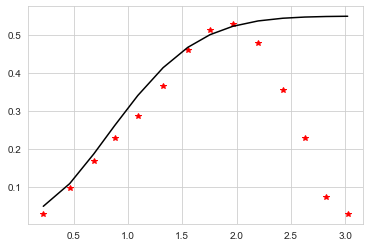


Oringdary Kriging:
Mean Absolute error: 0.3241


In [64]:
# best_params =  {'method': 'ordinary', 'nlags': 14, 'variogram_model': 'gaussian', 'weight': False}
OK = OrdinaryKriging(
    train_data[:, 0],
    train_data[:, 1],
    train_obs,
    variogram_model="gaussian",
    variogram_parameters=[0.55, 2, 0.03],
    verbose=False,
    enable_plotting=True,
    nlags = 14,
    weight = False,
)
# input x,y coordinates, return predict value and variance
train_pred_ok = OK.execute(style="points", xpoints=train_data[:,0],ypoints= train_data[:,1])[0].data
train_residual_ok = np.abs(train_pred_ok - train_obs)
test_pred_ok = OK.execute(style="points", xpoints=test_data[:,0], ypoints=test_data[:,1])[0].data
test_residual_ok = np.abs(test_pred_ok - test_obs)
print("\nOringdary Kriging:")
print("=" * 40)
print("Mean Absolute error: {:.4f}".format(np.mean( test_residual_ok)))

In [70]:
# for point v2(3, 1.5)
v2_point= np.array([3,1.5]).reshape(1,-1)
v2_pred =[]
v2_pred.append(OK.execute(style="points", xpoints=3,ypoints= 1.5)[0].data)

## Model performance
- Performance on training data
- Performance on test data

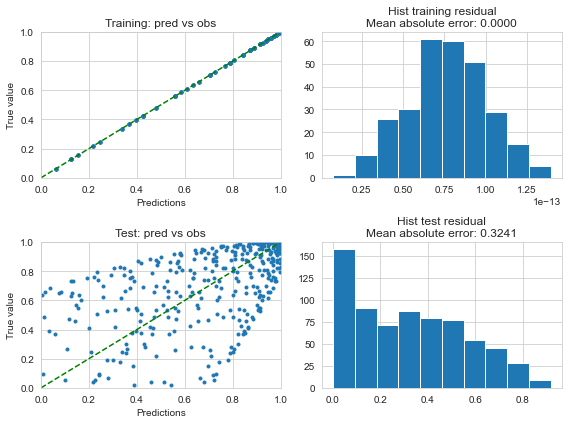

In [66]:
plt.figure(figsize=(8,6))
plt.subplot(221)
plt.plot(train_pred_ok, train_obs, '.')
plt.title('Training: pred vs obs')
plt.xlabel('Predictions')
plt.ylabel('True value')
plt.plot([0,1], [0,1], 'g--')
plt.ylim(0,1)
plt.xlim(0,1)
plt.subplot(222)
plt.hist(train_residual_ok)
plt.title('Hist training residual\nMean absolute error: {:.4f}'.format(np.mean(train_residual_ok)))
plt.subplot(223)
plt.plot(test_pred_ok, test_obs, '.')
plt.plot([0,1], [0,1], 'g--')
plt.title('Test: pred vs obs')
plt.xlabel('Predictions')
plt.ylabel('True value')
plt.ylim(0,1)
plt.xlim(0,1)
plt.subplot(224)
plt.hist(test_residual_ok)
plt.title('Hist test residual\nMean absolute error: {:.4f}'.format(np.mean(test_residual_ok)))
plt.tight_layout()

## Benchmarck with other methods
- Regression Kriging (regression model: svm, random forest, linearRegression)
- Nearest Neighbours regression
- Inverse Distance Weight (scipy's rbf with linear function)
- Spline interpolation (scipy's cubic)

In [71]:
import pandas as pd
import seaborn as sns
from scipy.interpolate import Rbf
from sklearn.neighbors import KNeighborsRegressor
from scipy.interpolate import interp2d
from pykrige.rk import RegressionKriging
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression 

model_name = ["Ordinary Kriging", "Regression Kriging(SVM)","Regression Kriging(RF)","Regression Kriging(linear)","Nearest Neighbours regression","Inverse Distance Weight","Spline"]

test_residual =[]
test_residual.append(test_residual_ok) # add the test residual of ordinary kriging

test_pred= []
test_pred.append(test_pred_ok) # add the test result of ordinary kriging

# Regression Kriging

svr_model = SVR(C=0.1, gamma="auto")
rf_model = RandomForestRegressor(n_estimators=100)
lr_model = LinearRegression(normalize=True, copy_X=True, fit_intercept=False)

models = [svr_model, rf_model, lr_model]
for m in models:
    print("Regression Kriging({})".format(m.__class__.__name__))
    m_rk = RegressionKriging(regression_model=m, n_closest_points=8)
    m_rk.fit(train_data,train_data,train_obs)
    test_pred_temp = m_rk.predict(test_data,test_data)
    test_residual_temp = np.abs(test_pred_temp-test_obs)
    print("Mean Absolute error: {:.4f}".format(np.mean(test_residual_temp)))
    print("=" * 40)
    print("\n")
    test_pred.append(test_pred_temp)
    test_residual.append(test_residual_temp)
    #for point v2(3,1.5)
    v2_pred.append(m_rk.predict(v2_point,v2_point))


# Nearest Neighbours regression
parameters = {'n_neighbors':np.arange(1,10)}
nn_model = KNeighborsRegressor()
nn_model_cv = GridSearchCV(nn_model, parameters)
nn_model_cv = nn_model_cv.fit(train_data, train_obs) 
#print('Optimal number of neighbours {}'.format(nn_model_cv.best_params_))
nn_model = nn_model_cv.best_estimator_
test_pred_nn = nn_model.predict(test_data)
test_residual_nn = np.abs(test_obs -test_pred_nn)

test_pred.append(test_pred_nn)
test_residual.append(test_residual_nn)
# for point v2(3,1.5)
v2_pred.append(nn_model.predict(v2_point)) 

print("Nearest Neighbours regression:")
print("Mean Absolute error: {:.4f}".format(np.mean(test_residual_nn)))
print("=" * 40)
print("\n")

# Inverse Distance Weight
rbf = Rbf(train_data[:,0], train_data[:,1], train_obs, epsilon=2,function='linear')
test_pred_idw = rbf(X_test, Y_test)
test_pred_idw = test_pred_idw.flatten()
test_residual_idw = np.abs(test_obs -test_pred_idw)

test_pred.append(test_pred_idw)
test_residual.append(test_residual_idw)
# for point v2(3,1.5)
v2_pred.append(rbf([3],[1.5]))
print("Inverse Distance Weight:")
print("Mean Absolute error: {:.4f}".format(np.mean( test_residual_idw )))
print("=" * 40)
print("\n")

# Spline interpolation
sp = interp2d(x, y, v, kind='cubic')
test_pred_sp = sp(x_tile_test, y_tile_test)
test_pred_sp = test_pred_sp.flatten()
test_residual_sp = np.abs(test_obs -test_pred_sp)
test_pred.append(test_pred_sp)
test_residual.append(test_residual_sp)
# for point v2(3,1.5)
v2_pred.append(sp([3],[1.5])) 
print("Spline interpolation:")
print("Mean Absolute error: {:.4f}".format(np.mean( test_residual_sp )))
print("=" * 40)

Regression Kriging(SVR)
Finished learning regression model
Finished kriging residuals
Mean Absolute error: 0.2716


Regression Kriging(RandomForestRegressor)
Finished learning regression model
Finished kriging residuals
Mean Absolute error: 0.2927


Regression Kriging(LinearRegression)
Finished learning regression model
Finished kriging residuals
Mean Absolute error: 0.3296


Nearest Neighbours regression:
Mean Absolute error: 0.2922


Inverse Distance Weight:
Mean Absolute error: 0.3137


Spline interpolation:
Mean Absolute error: 0.2914


Text(0.5, 1.0, 'Compairing absolute errors')

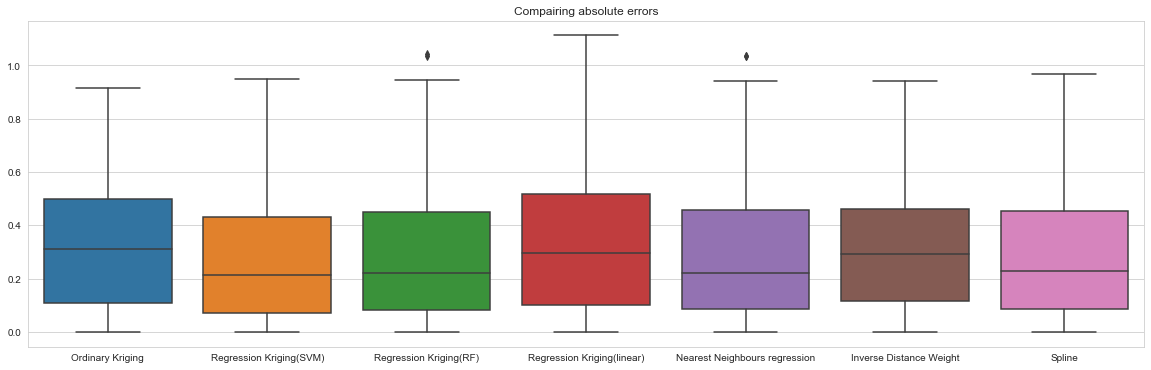

In [72]:
df = pd.DataFrame(data= np.array(test_residual).transpose(), columns=model_name)
sns.set_style("whitegrid")
plt.figure(figsize=(20,6))
g =sns.boxplot(data=df)
plt.title('Compairing absolute errors')

In [78]:
# take (3,1.5) for example
print("True value at point (3,1.5): {:0.5f}".format(v2))
print("\n")
print("predited value:")
for i in range(len(model_name)):
    print("{}: {:0.5f}".format(model_name[i],v2_pred[i][0]))


True value at point (3,1.5): -0.94634


predited value:
Ordinary Kriging: -0.95851
Regression Kriging(SVM): -0.75940
Regression Kriging(RF): -0.82344
Regression Kriging(linear): -0.47983
Nearest Neighbours regression: -0.82390
Inverse Distance Weight: -0.91539
Spline: -0.82390


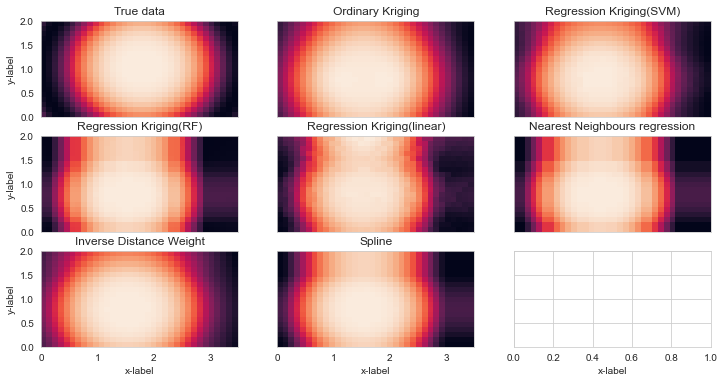

In [79]:
 fig, axs = plt.subplots(3, 3,figsize=(12,6))
 axs = axs.ravel()
 axs[0].pcolor(x_tile_test,y_tile_test,v_test)
 axs[0].set_title("True data")
 
 for i in range(len(test_pred)):
      grid = test_pred[i].reshape(v_test.shape[0],v_test.shape[1])
      axs[i+1].pcolor(x_tile_test,y_tile_test,grid)
      axs[i+1].set_title(model_name[i])

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()      